In [1]:
import pandas as pd
import numpy as np
import tarfile
from scipy.spatial import distance
from skimage import io
from skimage.transform import rescale
import ml_02_pca
%reload_ext version_information
np.__version__, pd.__version__

('1.16.4', '0.24.2')

<h3>Einlesen der .tgz-Datei mithilfe von <I>tarfile</I></h3>

In [2]:
tar = tarfile.open("lfw-funneled.tgz")
#tar.extractall() #gefährlich, entpackt direkt alles

In [3]:
i = 0
for tarinfo in tar:
    print(tarinfo.name, "is", tarinfo.size, "bytes in size and is ", end="")
    if tarinfo.isreg():
        print("a regular file.")
    elif tarinfo.isdir():
        print("a directory.")
    else:
        print("something else.")
        
    i+=1
    if i == 20:
        break


lfw_funneled is 0 bytes in size and is a directory.
lfw_funneled/George_HW_Bush is 0 bytes in size and is a directory.
lfw_funneled/George_HW_Bush/George_HW_Bush_0001.jpg is 17691 bytes in size and is a regular file.
lfw_funneled/George_HW_Bush/George_HW_Bush_0002.jpg is 14895 bytes in size and is a regular file.
lfw_funneled/George_HW_Bush/George_HW_Bush_0003.jpg is 18220 bytes in size and is a regular file.
lfw_funneled/George_HW_Bush/George_HW_Bush_0004.jpg is 17493 bytes in size and is a regular file.
lfw_funneled/George_HW_Bush/George_HW_Bush_0005.jpg is 21517 bytes in size and is a regular file.
lfw_funneled/George_HW_Bush/George_HW_Bush_0006.jpg is 17631 bytes in size and is a regular file.
lfw_funneled/George_HW_Bush/George_HW_Bush_0007.jpg is 20535 bytes in size and is a regular file.
lfw_funneled/George_HW_Bush/George_HW_Bush_0008.jpg is 17979 bytes in size and is a regular file.
lfw_funneled/George_HW_Bush/George_HW_Bush_0009.jpg is 16926 bytes in size and is a regular file.

<h3>2a) Zwischenspeichern der Personen mit mindestens 70 Bildern</h3>

In [4]:
i = 0
popular = []
for tarinfo in tar:
    if tarinfo.isdir():
        person = tarinfo.name
        i = 0
    elif tarinfo.isreg() and tarinfo.name.endswith("jpg"):
        i += 1
    if i >= 70:
        if person not in popular:
            popular.append(person)
            print(person)
        

lfw_funneled/Gerhard_Schroeder
lfw_funneled/George_W_Bush
lfw_funneled/Donald_Rumsfeld
lfw_funneled/Tony_Blair
lfw_funneled/Ariel_Sharon
lfw_funneled/Colin_Powell
lfw_funneled/Hugo_Chavez


<h3>2b) Zwischenspeichern der Bilder der am häufigsten abgebildeten Personen</h3>

Je ein Bild wird für die Klassifikation beiseite gelegt.

Zuerst Zwischenspeichern der Namen der Bilddateien, nach Personen getrennt, in einer Liste von Listen

In [5]:
popular_b = False
picturenames = []
pct = []
for tarinfo in tar:
    if tarinfo.isdir() and tarinfo.name in popular:
        popular_b = True
    elif tarinfo.isdir() and tarinfo.name not in popular:
        # Falls ein eine viel abgebildete Person voranging ist popular_b true
        # In diesem Fall wird pct gespeichert
        if popular_b:
            picturenames.append(pct)
            pct = []
        popular_b = False

    if popular_b == True and tarinfo.name.endswith("jpg"):
        pct.append(tarinfo.name)
# Falls die letzte Person viel abgebildet wurde wird zur Sicherheit pct gespeichert
if popular_b:
    picturenames.append(pct)
    pct = []

In [6]:
for plist in picturenames:
    print(len(plist))

109
530
121
144
77
236
71


In [7]:
np.shape(io.imread("lfw_funneled/George_HW_Bush/George_HW_Bush_0001.jpg", as_gray=True))

(250, 250)

Ausschneiden eines einheitlichen zentralen Ausschnittes, der nur Augen und
Mund enthält. Skalierung der Bilder auf die Größe 32 × 32 und Planieren der Matrizen zu Arrays.

In [8]:
pictures = []
class_pictures = []

for plist in picturenames:
    pct = []
    for picturename in plist:
        # Zentralen Ausschnitt mit Augen und Mund auswählen, Parameter durch Probieren erzeugt
        picture = io.imread(picturename, as_gray=True)[75:175, 75:175]
        picture = rescale(picture, 0.32, anti_aliasing=False, multichannel=False)
        picture = picture.flatten()
        # Beiseitelegen des jeweils letzten Bildes
        if picturename == plist[-1]:
            class_pictures.append(picture)
        else:
            pct.append(picture)
    pictures.append(pct)

In [9]:
np.shape(class_pictures[0])

(1024,)

In [10]:
#io.imshow(class_pictures[0])

In [11]:
all_cnt = []
for plist in pictures:
    all_cnt.append(len(plist))
all_cnt

[108, 529, 120, 143, 76, 235, 70]

In [12]:
np.sum(all_cnt)

1281

<h3>2c) Anwenden der Hauptkomponentenanalyse aus Aufgabe 2_1 auf die Designmatrix
(Alle Trainingsbilder für alle Personen wurden als Zeilen in eine gemeinsame
Designmatrix kopiert).</h3>

Aneinanderketten der Bildarrays zu einer N x D Designmatrix.

In [13]:
design = np.zeros((2,np.shape(class_pictures[0])[0])) #Hilfsmatrix
for plist in pictures:
    #for picture in plist:
    design = np.concatenate((design, plist), axis=0)
design = design[2:,:]

In [14]:
np.shape(design)

(1281, 1024)

In [15]:
design

array([[0.07255804, 0.14642254, 0.69799381, ..., 0.67256275, 0.66216998,
        0.7716511 ],
       [0.32706059, 0.264101  , 0.23566874, ..., 0.23916836, 0.21291464,
        0.24733636],
       [0.12790377, 0.20839775, 0.27509343, ..., 0.11599061, 0.12849176,
        0.14394652],
       ...,
       [0.02033686, 0.03258099, 0.05658798, ..., 0.52454691, 0.37260891,
        0.5274388 ],
       [0.12844077, 0.20023825, 0.23236636, ..., 0.25732409, 0.25856665,
        0.25450001],
       [0.1066688 , 0.14418403, 0.29712532, ..., 0.27716302, 0.19969916,
        0.17760734]])

Umwandeln der Matrix in ein Pandas Dataframe

In [16]:
df = pd.DataFrame.from_records(design)

Hauptkomponentenanalyse mit dem Modul aus Aufgabe 1

In [17]:
pc, ai, quadd, means = ml_02_pca.pca(df, 150)

In [18]:
np.shape(pc)

(150, 1024)

Darstellen der ersten 12 berechneten Hauptkomponenten als Bilder

In [19]:
eg = []
i = 0
for g in pc:
    eg.append(np.resize(g, (32,32)))
    i += 1
    if i == 12:
        break

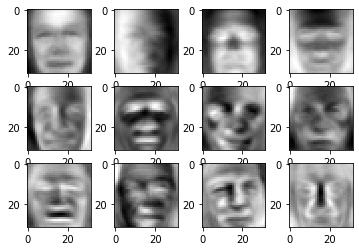

In [32]:
test = io.imshow_collection(eg, cmap='gray')

Darstellen der ersten 150 Eigenwerte in einem Diagramm

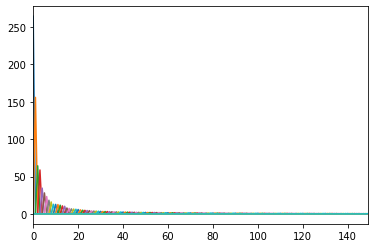

In [40]:
eigwert = np.diag(quadd[0:150])
eigwert = pd.DataFrame.from_records(eigwert)
eigwert.plot(legend=False)

Interpretation des Ergebnisses

Die letzten 100 Eigenwerte haben quasi keinen Einfluss.

<h3> 2d) Von den Testbildern wird nun ebenfalls der Mittelwert der Trainingsdaten abgezogen (s.
Schritt 1 im Algorithmus). 

Projektion jedes der Trainings- und Testbilder auf die ersten 7 Eigengesichter. 
Die Gesichtserkennung durch den euklidischen Abstand des Testbildes
in diesem 7-dimensionalen Merkmalsraum zu allen Trainingsbildern. Die Person
des am nächsten liegenden Trainingsbildes (d.h. mit dem minimalen euklidischen Abstand) ist
dann (vermutlich) auch die korrekte Person für das Testbild (Nächster-Nachbar-Klassifikator).
</h3>


In [22]:
popular

['lfw_funneled/Gerhard_Schroeder',
 'lfw_funneled/George_W_Bush',
 'lfw_funneled/Donald_Rumsfeld',
 'lfw_funneled/Tony_Blair',
 'lfw_funneled/Ariel_Sharon',
 'lfw_funneled/Colin_Powell',
 'lfw_funneled/Hugo_Chavez']

In [23]:
before = []
after = []
for c_pct in class_pictures:
    before.append(np.resize(c_pct, (32,32)))
    c_pct = c_pct - means
    after.append(np.resize(c_pct, (32,32)))

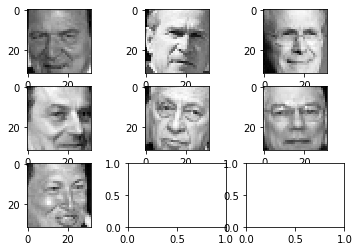

In [30]:
test = io.imshow_collection(before, cmap='gray')

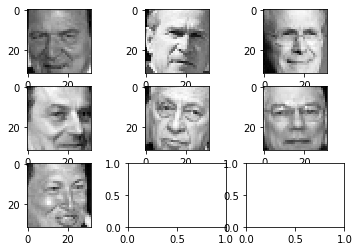

In [31]:
test = io.imshow_collection(after, cmap='gray')

In [26]:
distances = []
for c_pct in after:
    dst = []
    for g in eg[0:7]:
        d = distance.euclidean(c_pct.flatten(), g.flatten())
        dst.append(d)
    distances.append(dst)
#dst = distance.euclidean(eg[0], after[0])
distances

[[16.386503785135556,
  17.39593158543281,
  17.47656422167317,
  17.255444033851628,
  17.39971843669607,
  17.296129871480602,
  17.441298817064453],
 [20.764127888956036,
  21.565531943947736,
  21.82522538616664,
  21.66932739877075,
  21.710091698737642,
  21.662616240200823,
  21.656196094049054],
 [18.891855548003353,
  20.027703360484406,
  19.891979348991313,
  19.873856701061232,
  19.87627037296094,
  19.83923554858071,
  19.828894556371086],
 [17.57406445787115,
  18.44228904966376,
  18.63076334330757,
  18.47304879453772,
  18.5867006605303,
  18.474103934352044,
  18.557830673202208],
 [20.45700866379241,
  21.477520604412376,
  21.53466731286441,
  21.374647625490088,
  21.445888009432377,
  21.41277794937658,
  21.392177826925945],
 [14.473052173000596,
  15.411481839588086,
  15.580788920607,
  15.416792093775241,
  15.51354959659236,
  15.416671365020191,
  15.493439702631735],
 [16.34063039521611,
  17.23627338832955,
  17.343650230486453,
  17.241692361789273,
  17

In [27]:
for d in distances:
    print(d.index(min(d)))

0
0
0
0
0
0
0


Welche Bilder werden korrekt klassifiziert, welche Verwechslungen gibt es? 

Nur das erste wird (vermutlich) korrekt klassifiziert.

In [28]:
tar.close()

In [29]:
%version_information numpy, pandas, skimage, scipy

Software versions
Python 3.7.3 64bit [MSC v.1915 64 bit (AMD64)]
IPython 7.6.1
OS Windows 10 10.0.18362 SP0
numpy 1.16.4
pandas 0.24.2
skimage 0.15.0
scipy 1.2.1
Mon Nov 11 08:52:51 2019 Mitteleuropäische Zeit